# Helmholtz equation on Stanford bunny geometry - 2 (Trigonometric true solution)

In [2]:
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BasicAnsatz
from swimpde import HelmholtzSolver
import numpy as np
from sklearn.metrics import mean_squared_error
import pylab as p
import matplotlib.cm as cm
import numpy as np
import time
import matplotlib.pyplot as plt
cmap =cm.seismic


### Load and process data

In [6]:
# Load data
X_train = np.load('../../data/exponential/exp_bunny_train_interior.npy')
boundary_train = np.load('../../data/exponential/exp_bunny_train_boundary.npy')
X_test = np.load('../../data/exponential/exp_bunny_test_interior.npy')
boundary_test = np.load('../../data/exponential/exp_bunny_test_boundary.npy')

# Set domain 
interior_points = X_train
boundary_points = boundary_train
domain = Domain(
    interior_points=interior_points,
    boundary_points=boundary_points,)

FileNotFoundError: [Errno 2] No such file or directory: '../../exp_bunny_train_interior.npy'

### Problem setup and SWIM and ELM models

In [3]:
# This is mentioned just to pass it as an argument!
boundary_condition = "zero dirichlet" #"periodic strict" #strict

# forcing
def forcing(v):
    u = 5. + np.sin(np.pi * v[:, 0]) * np.sin(1 * np.pi * v[:, 1])  * np.sin(4 * np.pi * v[:, 2]) 
    u_xx = -18. * np.pi**2 * (u - 5.)
    return u_xx - u

def analytical_sol(v):
    return 5. + np.sin(np.pi * v[:, 0]) * np.sin(1 * np.pi * v[:, 1])  * np.sin(4 * np.pi * v[:, 2]) 

# True solution
Y_train = analytical_sol(X_train)
Y_test = analytical_sol(X_test)

# Store errors and time required for each seed
seeds = [1, 2, 3]
rel_err_swim = np.ones((len(seeds), ))
time_swim = np.ones((len(seeds), ))
rmse_swim = np.ones((len(seeds), ))
rel_err_elm = np.ones((len(seeds), ))
time_elm = np.ones((len(seeds), ))
rmse_elm = np.ones((len(seeds), ))

j = 0
for seed in seeds:
    ansatz_elm = BasicAnsatz(
        activation='tanh',
        n_neurons=4000,
        random_state=seed,
        regularization_scale=1e-12,
        parameter_sampler="random"
    )
    ansatz_swim = BasicAnsatz(
        activation='tanh',
        n_neurons=4000,
        random_state=seed,
        regularization_scale=1e-12
    )
    helmholtz_solver_elm = HelmholtzSolver(
                        domain=domain, 
                        ansatz=ansatz_elm,
                        forcing=forcing,
                        regularization_scale=1e-12
    )
    helmholtz_solver_swim = HelmholtzSolver(
        domain=domain, 
        ansatz=ansatz_swim,
        forcing=forcing,
        regularization_scale=1e-12
    )
    t_elm_start = time.time()
    helmholtz_solver_elm.fit(num_svd=1600, analytical_sol=analytical_sol);
    t_elm_stop = time.time()
    time_elm[j] = t_elm_stop - t_elm_start

    t_swim_start = time.time()
    helmholtz_solver_swim.fit(num_svd=1600, analytical_sol=analytical_sol);
    t_swim_stop = time.time()
    time_swim[j] = t_swim_stop - t_swim_start

    # Evaluate for SWIM and ELM
    sol_test_elm  =  helmholtz_solver_elm.evaluate(X_test)
    sol_test_swim =  helmholtz_solver_swim.evaluate(X_test)

    # Evaluate metrics
    mse_elm = mean_squared_error(sol_test_elm, Y_test)  # mean squared error
    rmse_elm[j] = np.sqrt(mse_elm)  # Root Mean Squared Error
    mse_swim = mean_squared_error(sol_test_swim, Y_test)  # mean squared error
    rmse_swim[j] = np.sqrt(mse_swim)  # Root Mean Squared Error
                    
    rel_err_elm[j] = np.linalg.norm(sol_test_elm - Y_test, 2)/np.linalg.norm(Y_test, 2)
    rel_err_swim[j] = np.linalg.norm(sol_test_swim - Y_test, 2)/np.linalg.norm(Y_test, 2)
    print('Relative L2 test error ELM: %e' % (rel_err_elm[j]))
    print('Relative L2 test error SWIM: %e' % (rel_err_swim[j]))
    j = j + 1


# RMSE and relative l-2 errors (mean and std) and time measurements
print('time_swim = ', np.mean(time_swim), 'time_elm = ', np.mean(time_elm))
print('rmse elm = ', np.mean(rmse_elm), '+-', np.std(rmse_elm))
print('rmse swim = ', np.mean(rmse_swim), '+-', np.std(rmse_swim))
print('rel error elm = ', np.mean(rel_err_elm), '+-', np.std(rel_err_elm))
print('rel error swim = ', np.mean(rel_err_swim), '+-', np.std(rel_err_swim))


Relative L2 test error ELM: 7.650793e-04
Relative L2 test error SWIM: 6.348851e-04
Relative L2 test error ELM: 1.687487e-03
Relative L2 test error SWIM: 9.531423e-04
Relative L2 test error ELM: 3.427593e-04
Relative L2 test error SWIM: 1.628552e-03
time_swim =  123.52064728736877 time_elm =  129.41006620724997
rmse elm =  0.00470398960146148 +- 0.002834656801966674
rmse swim =  0.005412878692393502 +- 0.0020915866268049936
rel error elm =  0.0009317750968678667 +- 0.0005614941443363399
rel error swim =  0.0010721931796728414 +- 0.0004143054081567822


'\n\n'

### Plot test errors on the Stanford bunny

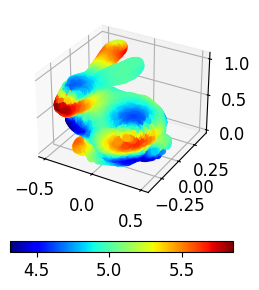

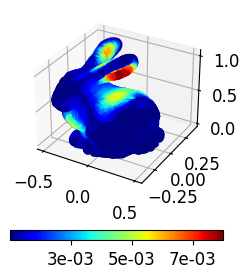

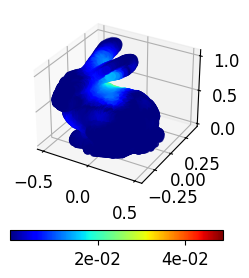

In [5]:
# Absolute errors to be used in plots
abs_err_elm = abs(sol_test_elm-Y_test)
abs_err_swim = abs(sol_test_swim-Y_test)

fontsize = 12

# Plot of ground truth
fig = p.figure(figsize=(4, 3))
cmap =cm.jet
ax= fig.add_subplot(projection='3d')
true_plot = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=Y_test, 
                          marker='o', cmap=cmap)# vmin=datamin, vmax=datamax,
plt.tick_params(axis='both', labelsize=fontsize)
cb = fig.colorbar(true_plot, ax=ax, location='bottom',fraction=0.046)
cb.ax.tick_params(labelsize=fontsize)
fig.tight_layout()
plt.savefig('cg2_true_sol_abs.pdf', bbox_inches="tight")

# Plot of relative error
fig = p.figure(figsize=(4, 3))
ax =fig.add_subplot(projection='3d')#
rel_err_plot = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=abs_err_elm, 
                          marker='o', cmap=cmap)
cb = fig.colorbar(rel_err_plot , ax=ax , location='bottom',fraction=0.046, format='%.0e')
cb.ax.tick_params(labelsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.savefig('cg2_abs_err_elm_.pdf', bbox_inches="tight")


# Plot of relative error
fig = p.figure(figsize=(4, 3))
ax =fig.add_subplot(projection='3d')#
rel_err_plot = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=abs(abs_err_swim), 
                          marker='o', cmap=cmap) 
cb = fig.colorbar(rel_err_plot , ax=ax , location='bottom',fraction=0.046, format='%.0e')
cb.ax.tick_params(labelsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.savefig('cg2_abs_err_swim.pdf', bbox_inches="tight")

